In [1]:
#Importing Libries
import os
import zipfile
import numpy as np
import tensorflow as tf
import imageio as iio
from matplotlib.image import imread
import cv2
import nibabel as nib
from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from matplotlib.pyplot import cm
from tensorflow.keras.models import Model
import numpy as np
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import normalize

Using TensorFlow backend.


In [8]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
log_folder = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Train/logs'

In [10]:
%reload_ext tensorboard

In [11]:
!rm -rf /logs/

In [12]:
rm -rf logs

In [13]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [2]:
# define location of dataset
directory = "/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Train"

In [3]:
#Loading Data
anomly_scan_path = []
count = 0 
Anomly_Scan = []
label = []
directory = "/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Train"
count = 0
for j in os.listdir(directory):
    if count == 1:
        break
    count += 1
    if not j.startswith('.'):
        directory = directory + '/' + j
        for y in os.listdir(directory):
            if not y.startswith('.'):
                Newdirectory = directory + '/' + y
                image = cv2.imread(Newdirectory)
                Anomly_Scan.append(image)

        
    directory = "/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Train"

In [4]:
AnomlyTrainAndVal = np.array(Anomly_Scan)

In [5]:
del Anomly_Scan

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
directory = '/Users/kareemel-mallahy/Desktop/Graduation Project/NormalVideos'
normal_scan_path = []
count = 0

for x in os.listdir(directory):
    if count >= 10000:
        break
    
    newDirc = directory + '/' + x
    image = cv2.imread(newDirc)
    normal_scan_path.append(image)
    count += 1

In [7]:
print(len(normal_scan_path))
NormalTrainAndVal = np.array(normal_scan_path)
del normal_scan_path

10000


In [8]:
"""print(AnomlyTrainAndVal.shape)
print(NormalTrainAndVal.shape)
AnomlyTrainAndVal = normalize(AnomlyTrainAndVal,axis = 1)
print(AnomlyTrainAndVal.shape)

NormalTrainAndVal = normalize(NormalTrainAndVal,axis = 1)
print(NormalTrainAndVal.shape)"""

'print(AnomlyTrainAndVal.shape)\nprint(NormalTrainAndVal.shape)\nAnomlyTrainAndVal = normalize(AnomlyTrainAndVal,axis = 1)\nprint(AnomlyTrainAndVal.shape)\n\nNormalTrainAndVal = normalize(NormalTrainAndVal,axis = 1)\nprint(NormalTrainAndVal.shape)'

In [9]:
# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(AnomlyTrainAndVal))])
normal_labels = np.array([0 for _ in range(len(NormalTrainAndVal))])

#x_train = x_train[0:5 , : , : , :]

In [10]:
POSITIVE_CLASS = 1
BAG_COUNT = 25
VAL_BAG_COUNT = 22
BAG_SIZE = 100
PLOT_SIZE = 100
ENSEMBLE_AVG_COUNT = 1

In [11]:
#Creating Bags (MIL)
def Bags(data, labels, positiveClass, NumberOfInstaces):
    Allbags = []
    bag_labels = []
    
    counter = 0
    count = 0
    
    x = True
    
    while x:
        label = 0
        bags = []
        for w in range (0, NumberOfInstaces):
            bags.append(data[counter])
            
            if labels[counter] == 1:
                label = positiveClass
            
            counter += 1

        count += NumberOfInstaces
        bags = np.array(bags)
        Allbags.append(bags)
        bag_labels.append(label)
        if(len(data) - count >= NumberOfInstaces):
            x = True
        else:
            x = False
    
    return Allbags, bag_labels

In [12]:
anomlyVid, anomlyLab = Bags(AnomlyTrainAndVal, abnormal_labels, 1, 400)

In [13]:
anomlyVidTrain = np.array(anomlyVid)
anomlyLabTrain = np.array(anomlyLab)
print(len(anomlyVid))
print(len(anomlyLab))

58
58


In [14]:
print(anomlyVidTrain.shape)
print(anomlyVidTrain.shape)

(58, 400, 64, 64, 3)
(58, 400, 64, 64, 3)


In [15]:
del AnomlyTrainAndVal, abnormal_labels, anomlyVid, anomlyLab

In [16]:
print("Shape of X_train:", anomlyVidTrain.shape)
print("Shape of Bag:", anomlyVidTrain[0].shape)
print("Shape of Frame:", anomlyVidTrain[0][0].shape)

Shape of X_train: (58, 400, 64, 64, 3)
Shape of Bag: (400, 64, 64, 3)
Shape of Frame: (64, 64, 3)


In [17]:
NormalVid, normalLab = Bags(NormalTrainAndVal, normal_labels, 1, 400)

In [18]:
NormalVidTrain = np.array(NormalVid)
normalLabTrain = np.array(normalLab)
print(len(NormalVid))
print(len(normalLab))

25
25


In [19]:
print(NormalVidTrain.shape)
print(normalLabTrain.shape)

(25, 400, 64, 64, 3)
(25,)


In [20]:
del NormalTrainAndVal, normal_labels, NormalVid, normalLab

In [21]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
x_val = np.concatenate((anomlyVidTrain[:10], NormalVidTrain[:10]), axis=0)
y_val = np.concatenate((anomlyLabTrain[:10], normalLabTrain[:10]), axis=0)

In [22]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
x_train = np.concatenate((anomlyVidTrain[10:], NormalVidTrain[10:]), axis=0)
y_train = np.concatenate((anomlyLabTrain[10:], normalLabTrain[10:]), axis=0)

In [23]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

63
63
20
20


In [24]:
del anomlyVidTrain, NormalVidTrain, anomlyLabTrain, normalLabTrain

In [25]:
y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='float32')

In [26]:
for i in range (0, len(y_train)):
    print(y_train[i])

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]


In [27]:
y_val = tf.keras.utils.to_categorical(
    y_val, num_classes=2, dtype='float32')

In [28]:
print(y_val)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [29]:
print(x_train.shape)

(63, 400, 64, 64, 3)


In [30]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D

# Define model
weight_decay = 0.00005
l2=keras.regularizers.l2

model = Sequential()
model.add(Conv3D(2,(3,3,3),
                        input_shape=(400, 64, 64, 3),
                        activation='relu'))
model.add(Conv3D(4,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2a_a', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


model.add(Conv3D(8,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2b_a', activation = 'relu'))
model.add(Conv3D(16,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2b_b', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))


model.add(Conv3D(32,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2c_a', activation = 'relu'))
model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2c_b', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))


model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2d_2'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2d_3'))


#model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
#model.add(Flatten())
model.add(GlobalAveragePooling3D())
model.add(Dropout(0.5))
model.add(Dense(2,kernel_initializer='normal'))

model.add(Activation('softmax'))

In [31]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 398, 62, 62, 2)    164       
_________________________________________________________________
Conv3D_2a_a (Conv3D)         (None, 398, 62, 62, 4)    216       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 199, 31, 31, 4)    0         
_________________________________________________________________
Conv3D_2b_a (Conv3D)         (None, 199, 31, 31, 8)    864       
_________________________________________________________________
Conv3D_2b_b (Conv3D)         (None, 199, 31, 31, 16)   3456      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 99, 15, 15, 16)    0         
_________________________________________________________________
Conv3D_2c_a (Conv3D)         (None, 99, 15, 15, 32)   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_ACC = ModelCheckpoint("/Users/kareemel-mallahy/Desktop/Graduation Project/Models/SDGModelLSTM_2_Acc_3.h5", monitor='acc',save_best_only=True, verbose=1, mode='auto')
checkpoint_Val_ACC = ModelCheckpoint("/Users/kareemel-mallahy/Desktop/Graduation Project/Models/SDGModelLSTM_2_Val_Acc_3.h5", monitor='val_acc',save_best_only=True, verbose=1, mode='auto')

In [45]:
log_folder = 'logs'
from tensorflow.keras.callbacks import TensorBoard
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]


In [32]:
"""# Train the model, doing validation at the end of each epoch
from tensorflow import keras
from tensorflow.keras import layers
epochs = 20
print(x_train.shape)
model = tf.keras.models.load_model('/Users/kareemel-mallahy/Desktop/Graduation Project/Models/SDGModelLSTM_1_Acc_3.h5')"""
from tensorflow.python.keras.callbacks import TensorBoard
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['acc'])
model.fit(x_train,y_train,batch_size=10,
          validation_data=(x_val, y_val), epochs=90)

Train on 63 samples, validate on 20 samples
Epoch 1/90
63/63 [==============================] - 144s 2s/step - loss: 0.7549 - acc: 0.7619 - val_loss: 0.8315 - val_acc: 0.5000
Epoch 2/90


KeyboardInterrupt: 

In [ ]:
http://localhost:6006

In [ ]:
%tensorboard -- logdir={log}

In [36]:
model = tf.keras.models.load_model('/Users/kareemel-mallahy/Desktop/Graduation Project/Models/3DCNN-LSTM-BestPrediction.h5')

In [37]:
test = []
labels = []

path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Arrest'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
    
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Arson'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
    
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Assault'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
        
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Burglary'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
        
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Explosion'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
    
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Fighting'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
    
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/RoadAccidents'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
    
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Robbery'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Shooting'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Shoplifting'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Stealing'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)
    
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/Vandalism'
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(1)

In [38]:
path = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Test/NormalVideos'
count = 0
for x in os.listdir(path):
    test.append(cv2.imread(path + '/' + x))
    labels.append(0)

KeyboardInterrupt: 

In [39]:
print(len(test))
print(len(labels))

83588
83588


In [40]:
import matplotlib.pyplot as pl
from tensorflow.keras.preprocessing import image
for i in range(0, len(test)):
    test[i] = image.img_to_array(test[i])

In [41]:
def Bags(data, NumberOfInstaces):
    Allbags = []
    
    counter = 0
    count = 0
    
    x = True
    
    while x:
        bags = []
        for w in range (0, NumberOfInstaces):
            bags.append(data[counter])
            counter += 1

        count += NumberOfInstaces
        bags = np.array(bags)
        Allbags.append(bags)
        if(len(data) - count >= NumberOfInstaces):
            x = True
        else:
            x = False
    
    return Allbags

In [42]:
def BagsLabels(data, labels, positiveClass, NumberOfInstaces):
    Allbags = []
    bag_labels = []
    
    counter = 0
    count = 0
    
    x = True
    
    while x:
        label = 0
        bags = []
        for w in range (0, NumberOfInstaces):
            bags.append(data[counter])
            
            if labels[counter] == 1:
                label = positiveClass
            
            counter += 1

        count += NumberOfInstaces
        bags = np.array(bags)
        Allbags.append(bags)
        bag_labels.append(label)
        if(len(data) - count >= NumberOfInstaces):
            x = True
        else:
            x = False
    
    return bag_labels

In [43]:
test = np.array(test)
print(test.shape)

(83588, 64, 64, 3)


In [44]:
testFinal = []
labelsFinal = []
i = 0
print(len(test))
while i < len(test): 
    print(i)
    if i + 400 <= len(test):
        print(i)
        testFinal.append(Bags(test[i:i+400], 400))
        labelsFinal.append(BagsLabels(test[i:i+400], labels[i:i+400], 1, 400))
    i += 400

83588
0
0
400
400
800
800
1200
1200
1600
1600
2000
2000
2400
2400
2800
2800
3200
3200
3600
3600
4000
4000
4400
4400
4800
4800
5200
5200
5600
5600
6000
6000
6400
6400
6800
6800
7200
7200
7600
7600
8000
8000
8400
8400
8800
8800
9200
9200
9600
9600
10000
10000
10400
10400
10800
10800
11200
11200
11600
11600
12000
12000
12400
12400
12800
12800
13200
13200
13600
13600
14000
14000
14400
14400
14800
14800
15200
15200
15600
15600
16000
16000
16400
16400
16800
16800
17200
17200
17600
17600
18000
18000
18400
18400
18800
18800
19200
19200
19600
19600
20000
20000
20400
20400
20800
20800
21200
21200
21600
21600
22000
22000
22400
22400
22800
22800
23200
23200
23600
23600
24000
24000
24400
24400
24800
24800
25200
25200
25600
25600
26000
26000
26400
26400
26800
26800
27200
27200
27600
27600
28000
28000
28400
28400
28800
28800
29200
29200
29600
29600
30000
30000
30400
30400
30800
30800
31200
31200
31600
31600
32000
32000
32400
32400
32800
32800
33200
33200
33600
33600
34000
34000
34400
34400
34800
3480

In [45]:
print(len(testFinal))
print(len(labelsFinal))

208
208


In [46]:
testFinal = np.array(testFinal)
print(testFinal.shape)
print(testFinal.dtype)

(208, 1, 400, 64, 64, 3)
float32


In [47]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from numpy import argmax

FinalPredictions = []

count_normal = 0
count_Anomly = 0

for i in range(len(testFinal)):
    prediction = (model.predict(testFinal[i]))
    print(prediction)
    result = argmax(prediction)
    FinalPredictions.append(result)
    
    if result == 0:
        count_normal += 1
    else:
        count_Anomly += 1
    print(result)

[[0.1819219  0.81807816]]
1
[[0.26350778 0.73649216]]
1
[[0.2633677 0.7366322]]
1
[[0.3062765 0.6937235]]
1
[[0.2163405 0.7836596]]
1
[[0.17907982 0.8209202 ]]
1
[[0.2512987 0.7487012]]
1
[[0.16094242 0.83905756]]
1
[[0.17061226 0.8293877 ]]
1
[[0.15387227 0.8461278 ]]
1
[[0.16108727 0.8389128 ]]
1
[[0.13235822 0.8676418 ]]
1
[[0.14324759 0.85675246]]
1


KeyboardInterrupt: 

In [ ]:
#print("Nomral Predictions:",count_normal)
#print("Anomly Predictions:",count_Anomly)
print(len(FinalPredictions))



In [2]:
model.save("/Users/kareemel-mallahy/Desktop/Graduation Project/Models/3DCNN-LSTM-BestPrediction.h5")

NameError: name 'model' is not defined

In [15]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
report = metrics.classification_report(labelsFinal, FinalPredictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       161
           1       1.00      0.88      0.94       116

    accuracy                           0.95       277
   macro avg       0.96      0.94      0.95       277
weighted avg       0.95      0.95      0.95       277



[[161   0]
 [ 14 102]]


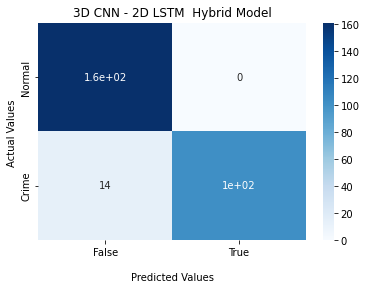

In [16]:
from sklearn.metrics import confusion_matrix
#Generate the confusion matrix
cf_matrix = confusion_matrix(labelsFinal, FinalPredictions)
print(cf_matrix)

import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('3D CNN - 2D LSTM  Hybrid Model');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['Normal','Crime'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
import imutils
# make bounding box predictions on the input image
preds = model.predict(testFinal[0])[0]
(startX, startY) = preds
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
imagePath = '/Users/kareemel-mallahy/Desktop/Graduation Project/DataSetFrames/Train/Arrest/Arrest002_x264_140.png'
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(startX * w + 20)
endY = int(startY * h + 20)
# draw the predicted bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY),
(0, 255, 0), 2)
# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)